In [ ]:
#vectors and matricies: make n-map, mean-image, t-map and p-map, threshold maps by numerical value or by significant voxels

In [1]:
from nilearn import image
from nilearn.image import load_img
from nilearn.image import math_img
from nilearn.image import threshold_img
from nilearn.image import resample_to_img
from nilearn.maskers import NiftiMasker
from scipy import stats
from scipy.io import loadmat
from scipy.stats import ttest_1samp
from scipy.stats import shapiro
from scipy.stats import norm
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib
import pandas as pd
import os, glob

In [2]:
#make matrix out of subjects using the binary n-map mask
def load_parcel_fc(mask,path):
    nifti_masker = NiftiMasker(mask_img=mask)
    fmri_masked = nifti_masker.fit_transform(path)
    print('finished')
    return nifti_masker, fmri_masked

path = glob.glob(os.path.join('/Volumes/Cingulate/Sweetspot_Seg/Subjects/Binary/z1-2 nii','*.nii'))
mask = '/Volumes/Cingulate/Sweetspot_Seg/Outputs/binary/zones1-2/binary_n-map.nii.gz'

mask_nii,first_matrix = load_parcel_fc(mask,path)

finished


In [2]:
#load matrix
def load_matrix():
    data = loadmat('/Volumes/Cingulate/Sweetspot_Seg/binary_subject_matrix.mat')
    first_matrix = data['first_matrix']
    masker = NiftiMasker(mask_img='/Volumes/Cingulate/Sweetspot_Seg/Outputs/binary/zones1-2/binary_n-map.nii.gz', standardize=True)
    mask_nii = masker.fit()
    return mask_nii, first_matrix

#index matrix and df by cohort
def matrix_df_selection(first_matrix,df_array):
    ranges = [(0, 3), (4, 5), (6, 18), (19, 21), (22, 25), (26, 27), (28, 29), (30, 32), (32, 33), (34, 37), (38, 39), (40, 47)]
    second_matrix,df_selection = first_matrix.copy(),df_array.copy()
    
    #make cohort matricies
    cingulotomy_rows = np.concatenate([np.arange(start, end) for start, end in ranges])
    cingulotomy_matrix = second_matrix[cingulotomy_rows]
    cap_sct_matrix = np.delete(second_matrix,cingulotomy_rows,axis=0)
    
    #make clinical outcomes cohorts
    cingulotomy_df = df_selection[cingulotomy_rows]
    cap_sct_df = np.delete(df_selection,cingulotomy_rows, axis=0)
    
    return cingulotomy_matrix, cap_sct_matrix, cingulotomy_df, cap_sct_df

df = pd.read_csv('/Volumes/Cingulate/Sweetspot_Seg/All_YBOCS_Vol_Cohort.csv')
df_array = df['Relative'].to_numpy().reshape(-1, 1) #change for absolute vs relative

mask_nii, first_matrix = load_matrix()
cingulotomy_matrix, cap_sct_matrix, cingulotomy_df, cap_sct_df = matrix_df_selection(first_matrix,df_array)

In [14]:
#sum each row up to get a vector and make an n-map, subcohort
n_matrix = cingulotomy_matrix.copy() #change for matrix subcohort
n_matrix[np.isnan(n_matrix)] = 0 #make nans 0

sum_vector = np.sum(n_matrix,axis=0)
sum_vector_reshape = sum_vector.reshape(1,-1)

n_map = mask_nii.inverse_transform(sum_vector_reshape[0])
n_map.to_filename('/Volumes/Cingulate/Sweetspot_Seg/Outputs/binary/zones1-2/cing_n-map.nii.gz')

In [15]:
#make the mean image, subcohort
#make 0s NaNs
mean_matrix = cingulotomy_matrix.copy()
mean_matrix[mean_matrix == 0] = np.nan

# repeat the rows to create a final array (71, 451938)
df_matrix = np.tile(cingulotomy_df, (1, 451938))

#multiply so each row has clinical outcomes
co_matrix = np.multiply(mean_matrix, df_matrix)

#sum each row up to get a vector and make a mean-image
co_sum_vector = np.nansum(co_matrix,axis=0)
co_sum_vector_reshape = co_sum_vector.reshape(1,-1)

mean_img = mask_nii.inverse_transform(co_sum_vector_reshape[0])
mean_img.to_filename('/Volumes/Cingulate/Sweetspot_Seg/Outputs/binary/zones1-2/cing_sum_img.nii.gz') #make sure to divide by the n-map when done

In [17]:
#make t-map and p-map
def t_test(matrix, df):
    def one_sample_t_test(col, null):
        no_nan_col = col[~np.isnan(col)]
        if len(no_nan_col) > 1:
            t_stat, p_value = ttest_1samp(no_nan_col, null)
            return t_stat, p_value
        else: #if there's not enough values left over, returns nan
            return np.nan, np.nan
    null = cingulotomy_df.mean() #change for population mean: df['Relative'].mean() or 0
    result = np.apply_along_axis(one_sample_t_test, axis=0, arr=co_matrix, null=null) #creates 2d array, first row is t, second is p

    t_statistics = result[0]
    p_values = result[1]
    
    #threshold for significant positive
    sig_t,sig_p = t_statistics.copy(), p_values.copy()
    sig_mask = (p_values > 0) & (p_values <= 0.05)
    sig_t[sig_mask == 0], sig_p[sig_mask == 0] = 0,0
    pos_sig_t,pos_sig_p = sig_t.copy(),sig_p.copy()
    pos_sig_t[sig_t < 0],pos_sig_p[sig_p < 0] = 0,0

    #threshold n-map
    threshold = 5
    thresholded_vector = np.array(sum_vector)
    thresholded_pos_sig_t = pos_sig_t.copy()
    thresholded_vector[thresholded_vector <= threshold] = 0

    binary_threshold_n_vector = thresholded_vector.copy()        
    binary_threshold_n_vector[binary_threshold_n_vector > 0] = 1
    thresholded_pos_sig_t[binary_threshold_n_vector == 0] = 0
    
    t_reshape = thresholded_pos_sig_t.reshape(1,-1)
    t_map = mask_nii.inverse_transform(t_reshape[0])
    t_map.to_filename('/Volumes/Cingulate/Sweetspot_Seg/Outputs/matrix_tests/cing_sig_pos_thresholded_avg_t-map.nii.gz')

    return thresholded_pos_sig_t

def overlap(thresholded_pos_sig_t):
    df_column = cingulotomy_df.flatten()
    matrix = cingulotomy_matrix
    score = np.zeros((matrix.shape[0]))

    for i in range(matrix.shape[0]):
        score[i] = np.mean(np.multiply(thresholded_pos_sig_t[matrix[i, :] != 0], matrix[i, matrix[i, :] != 0]))

    r, p = pearsonr(score, df_column)
    return score, r, p

def cross_validations(matrix, df):
    num_sub = matrix.shape[0]
    for i in range(num_sub):
        print(f'Iteration: {i + 1}/{num_sub}')
        current_subject_matrix = np.delete(matrix, i, axis=0) #exclude the i-th subject
        current_clinical_outcomes = np.delete(df, i, axis=0) #exclude i-th subject's clinical outcomes
        thresholded_pos_sig_t = t_test(current_subject_matrix,current_clinical_outcomes)
        score, r, p = overlap(thresholded_pos_sig_t)
    return score, r, p
        
matrix = cingulotomy_matrix
df = cingulotomy_df

thresholded_pos_sig_t = t_test(matrix,df)
# score, r, p = overlap(thresholded_pos_sig_t)
# score, r, p = cross_validations(matrix,df)

In [11]:
#make t-map and p-map
null = cingulotomy_df.mean() or 0 #change for population mean: df['Relative'].mean() or 0

def one_sample_t_test(col, null):
    no_nan_col = col[~np.isnan(col)]
    if len(no_nan_col) > 1:
        t_stat, p_value = ttest_1samp(no_nan_col, null)
        return t_stat, p_value
    else: #if there's not enough values left over, returns nan
        return np.nan, np.nan

result = np.apply_along_axis(one_sample_t_test, axis=0, arr=co_cing_matrix, null=null) #creates 2d array, first row is t, second is p

t_statistics = result[0]
p_values = result[1]

#save to nii
t_reshape, p_reshape= t_statistics.reshape(1,-1),p_values.reshape(1,-1)
t_map,p_map = mask_nii.inverse_transform(t_reshape[0]),mask_nii.inverse_transform(p_reshape[0])
t_map.to_filename('/Volumes/Cingulate/Sweetspot_Seg/Outputs/matrix_tests/python_cing_avg_t-map.nii.gz')
p_map.to_filename('/Volumes/Cingulate/Sweetspot_Seg/Outputs/matrix_tests/python_cing_avg_p-map.nii.gz')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [12]:
#thresholding for significant and positive
sig_t,sig_p = t_statistics.copy(), p_values.copy()
sig_mask = (p_values > 0) & (p_values <= 0.05)
sig_t[sig_mask == 0], sig_p[sig_mask == 0] = 0,0
pos_sig_t,pos_sig_p = sig_t.copy(),sig_p.copy()
pos_sig_t[sig_t < 0],pos_sig_p[sig_p < 0] = 0,0

sig_t_reshape,sig_p_reshape = sig_t.reshape(1,-1),sig_p.reshape(1,-1)
pos_sig_t_reshape,pos_sig_p_reshape = pos_sig_t.reshape(1,-1),pos_sig_p.reshape(1,-1)

sig_t_map = mask_nii.inverse_transform(sig_t_reshape[0])
sig_t_map.to_filename('/Volumes/Cingulate/Sweetspot_Seg/Outputs/matrix_tests/python_cing_sig_avg_t-map.nii.gz')

sig_p_map = mask_nii.inverse_transform(sig_p_reshape[0])
sig_p_map.to_filename('/Volumes/Cingulate/Sweetspot_Seg/Outputs/matrix_tests/python_cing_sig_avg_p-map.nii.gz')

pos_sig_t_map = mask_nii.inverse_transform(pos_sig_t_reshape[0])
pos_sig_t_map.to_filename('/Volumes/Cingulate/Sweetspot_Seg/Outputs/matrix_tests/python_cing_pos_sig_avg_t-map.nii.gz')

pos_sig_p_map = mask_nii.inverse_transform(pos_sig_p_reshape[0])
pos_sig_p_map.to_filename('/Volumes/Cingulate/Sweetspot_Seg/Outputs/matrix_tests/python_cing_pos_sig_avg_p-map.nii.gz')

In [32]:
#threshold n-map
threshold = 2
thresholded_vector = n_array.copy()
thresholded_pos_sig_t = pos_sig_t.copy()
thresholded_vector[thresholded_vector <= threshold] = 0

binary_threshold_n_vector = thresholded_vector.copy()        
binary_threshold_n_vector[binary_threshold_n_vector > 0] = 1
thresholded_pos_sig_t[binary_threshold_n_vector == 0] = 0

thresholded_pos_sig_t_reshape = thresholded_pos_sig_t.reshape(1,-1)
thresholded_pos_sig_t = mask_nii.inverse_transform(pos_sig_p_reshape[0])
thresholded_pos_sig_t.to_filename('/Volumes/Cingulate/Sweetspot_Seg/Outputs/matrix_tests/python_thresholded_cing_pos_sig_avg_t-map.nii.gz')

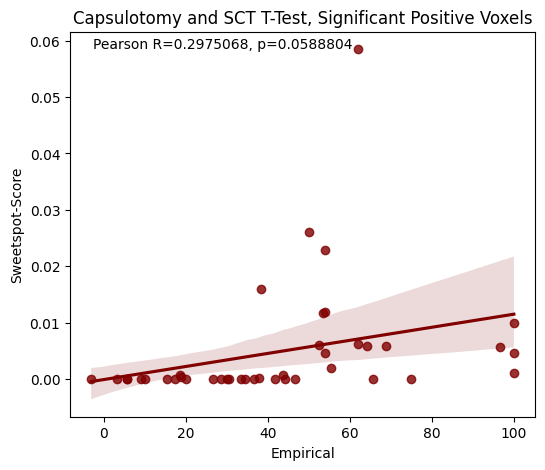

In [56]:
#capsulotomies & sct, relative
def plot_analysis(x_data, y_data, title, r,p, color):
    plt.figure(figsize=(6, 5))
    ax = sns.regplot(x=x_data, y=y_data, color=color)
    plt.title(title)
    plt.xlabel('Empirical')
    plt.ylabel('Sweetspot-Score')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(r, p),
            transform=ax.transAxes, verticalalignment='bottom')
    plt.show()

#pearson analysis
plot_analysis(cap_sct_df, score, 'Capsulotomy and SCT T-Test, Significant Positive Voxels', r,p, 'maroon')

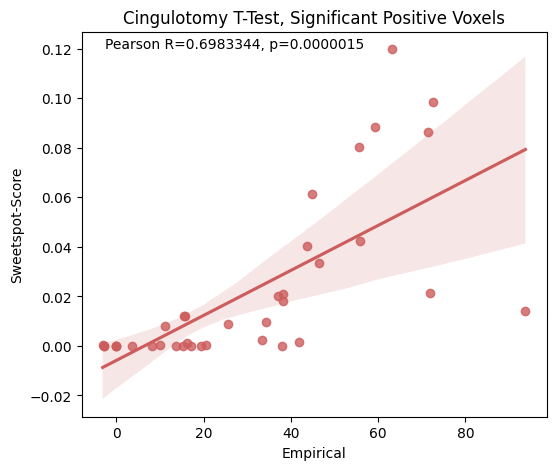

In [47]:
#cingulotomies, relative
def plot_analysis(x_data, y_data, title, r,p, color):
    plt.figure(figsize=(6, 5))
    ax = sns.regplot(x=x_data, y=y_data, color=color)
    plt.title(title)
    plt.xlabel('Empirical')
    plt.ylabel('Sweetspot-Score')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(r, p),
            transform=ax.transAxes, verticalalignment='bottom')
    plt.show()

#pearson analysis
plot_analysis(cingulotomy_df, score, 'Cingulotomy T-Test, Significant Positive Voxels', r,p, 'indianred')

In [30]:
#n-map
sub = [nib.load(f'/Volumes/Cingulate/Sweetspot_Seg/Sweetspot_Seg_All_Flipped/Bilat/Binary/z1-2_pos/{i}') for i in os.listdir('/Volumes/Cingulate/Sweetspot_Seg/Sweetspot_Seg_All_Flipped/Bilat/Binary/z1-2_pos') if i.endswith('.nii')]
n_map = math_img('img * 0', img=sub[0])

for i in range(len(sub)):
    n_map = math_img('img1 + img2', img1=n_map, img2=sub[i])
    
n_map.to_filename('/Volumes/Cingulate/Sweetspot_Seg/Outputs/python_pos_n-map.nii.gz')

In [8]:
#threshold 0 t-map to remove all values above 10
n_map = nib.load('/Volumes/Cingulate/Sweetspot_Seg/Outputs/matrix_tests/no_nan_avg_t-map.nii.gz')
n_array = n_map.get_fdata()
filtered_data = np.where(n_array < 5, n_array, 0)
filtered_nifti_img = nib.Nifti1Image(filtered_data, n_map.affine)
nib.save(filtered_nifti_img,'/Volumes/Cingulate/Sweetspot_Seg/Outputs/thresholded_avg_t-map.nii.gz')

#threshold avg p-map to remove all values above 10
n_map = nib.load('/Volumes/Empty/Sweetspot_Seg/Outputs/matrix_tests/python_avg_p-map.nii.gz')
n_array = n_map.get_fdata()
filtered_data = np.where(n_array < 0.05, n_array, 0)
filtered_nifti_img = nib.Nifti1Image(filtered_data, n_map.affine)
nib.save(filtered_nifti_img,'/Volumes/Empty/Sweetspot_Seg/Outputs/matrix_tests/thresholded_python_avg_p-map.nii.gz')

In [94]:
#threshold 0 t-map by 0 p-map
t_stat_0_map = load_img('/Volumes/Cingulate/Sweetspot_Seg/Outputs/matrix_tests/no_nan_0_t-map.nii.gz')
p_val_0_map = load_img('/Volumes/Cingulate/Sweetspot_Seg/Outputs/matrix_tests/no_nan_0_p-map.nii.gz')
p_0_mask = math_img('(img > {}) & (img <= {})'.format(0, 0.05), img=p_val_0_map)
thresholded_t_0_map = math_img('img1*img2',img1=t_stat_0_map,img2=p_0_mask)
nib.save(thresholded_t_0_map,'/Volumes/Cingulate/Sweetspot_Seg/Outputs/matrix_tests/thresholded_0_t_map.nii.gz')

#threshold avg t-map by avg p-map
t_stat_avg_map = load_img('/Volumes/Cingulate/Sweetspot_Seg/Outputs/matrix_tests/no_nan_avg_t-map.nii.gz')
p_val_avg_map = load_img('/Volumes/Cingulate/Sweetspot_Seg/Outputs/matrix_tests/no_nan_avg_p-map.nii.gz')
p_avg_mask = math_img('(img > {}) & (img <= {})'.format(0, 0.05), img=p_val_avg_map)
thresholded_t_avg_map = math_img('img1*img2',img1=t_stat_avg_map,img2=p_avg_mask)
nib.save(thresholded_t_avg_map,'/Volumes/Cingulate/Sweetspot_Seg/Outputs/matrix_tests/thresholded_avg_t_map.nii.gz')

In [5]:
#threshold t-map by thresholded n-map
t_stat_0_map = load_img('/Volumes/Cingulate/Sweetspot_Seg/Outputs/matrix_tests/thresholded_0_t_map.nii.gz')
thresholded_n_map = load_img('/Volumes/Cingulate/Sweetspot_Seg/Outputs/matrix_tests/binary_threshold_n-map.nii.gz')
threshold_t = math_img('img1*img2',img1=t_stat_0_map,img2=thresholded_n_map)
nib.save(threshold_t,'/Volumes/Cingulate/Sweetspot_Seg/Outputs/matrix_tests/threshold_10%_0_t-map.nii.gz')

Mean: 0.03424542148595926
Standard Deviation: 1.047019181975455
ShapiroResult(statistic=0.994543731212616, pvalue=0.6820753216743469)


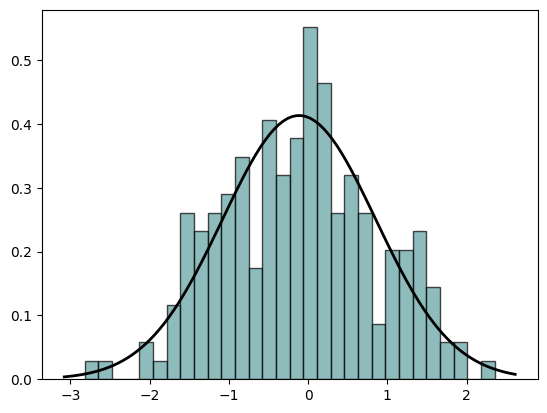

In [27]:
#generate a random normal distribution dataset
print('Mean:',np.mean(norm_data))
print('Standard Deviation:',np.std(norm_data))
print(shapiro(norm_data))

norm_data = np.random.normal(loc=0.0, scale=1.0, size=200)
count, bins, ignored = plt.hist(norm_data, 30, density=True, color='cadetblue', edgecolor='black', alpha=0.7)
mu, std = norm.fit(norm_data)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.show()

Mean: 0.42549384395594075
Standard Deviation: 3.0389806025568733
ShapiroResult(statistic=0.9478451609611511, pvalue=1.1760303095798008e-06)


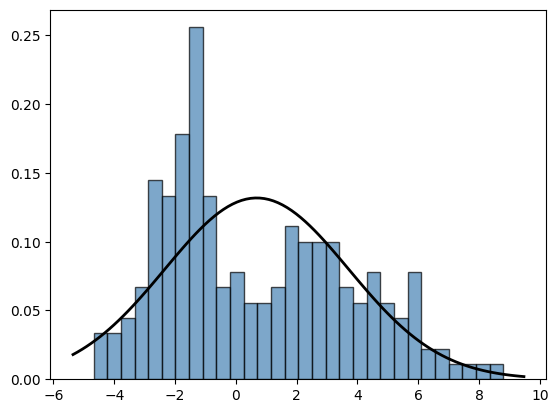

In [28]:
# Non-normally distributed dataset (bimodal)
print('Mean:',np.mean(non_norm_data))
print('Standard Deviation:',np.std(non_norm_data))
print(shapiro(non_norm_data))

data_1 = np.random.normal(loc=-2, scale=1, size=100)
data_2 = np.random.normal(loc=3, scale=2, size=100)
non_norm_data = np.concatenate([data_1, data_2])
count, bins, ignored = plt.hist(non_norm_data, 30, density=True, color='steelblue', edgecolor='black', alpha=0.7)
mu, std = norm.fit(non_norm_data)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.show()

In [89]:
#using functions example
def add(num):
    sum1 = num + 1
    prod = num * 2
 
    return sum1, prod

num = 9
sum_ans, prod_ans = add(num)